In [1]:
pip install requests

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install alpha_vantage

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install openai


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install tkcalendar matplotlib pandas numpy scikit-learn yfinance alpha_vantage joblib seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install lightgbm xgboost catboost


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


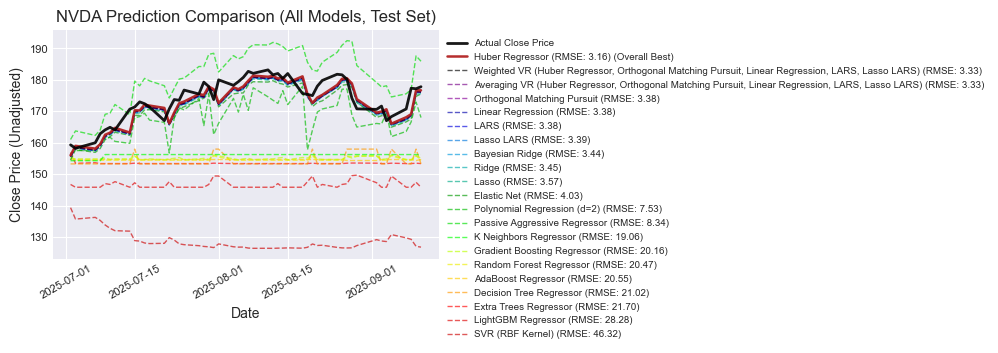

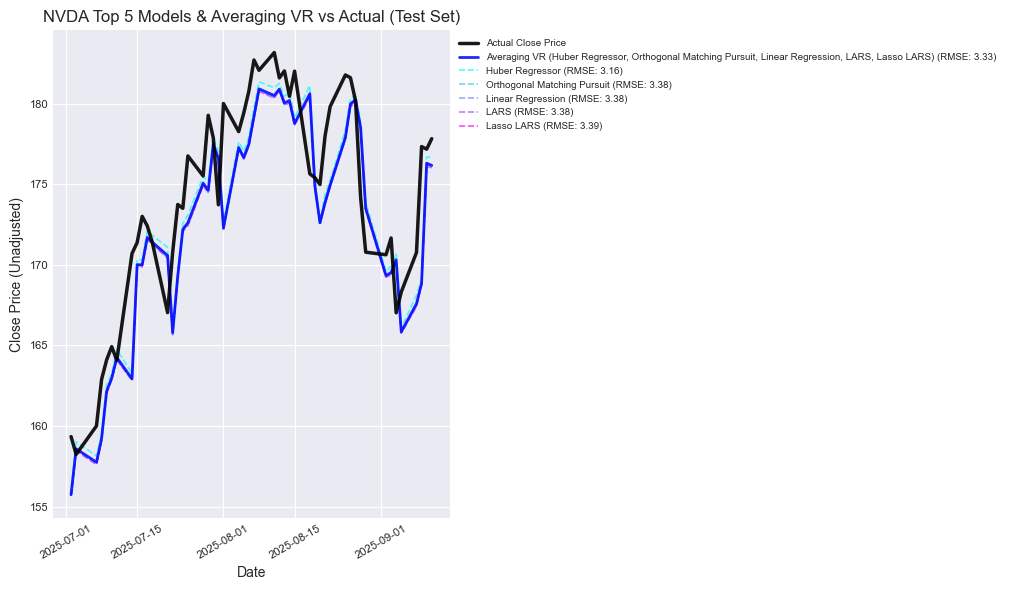

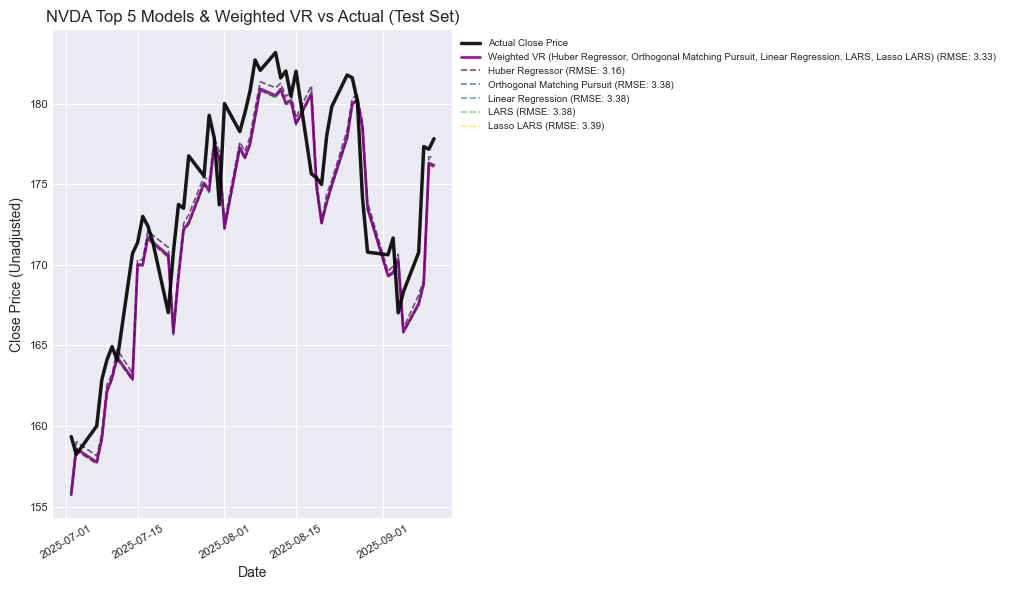

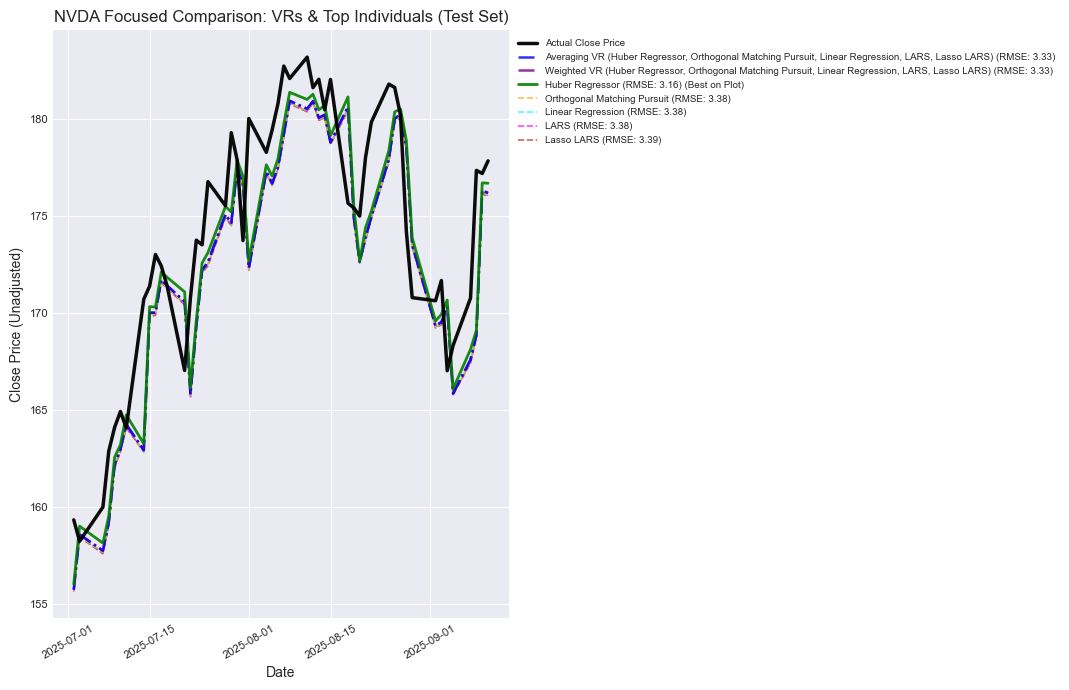

In [ ]:
import tkinter as tk
from tkinter import ttk, messagebox, scrolledtext
from tkcalendar import DateEntry
import pandas as pd
import numpy as np
# import yfinance as yf # yfinance is not directly used in the GUI part for resizing
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
import threading  # To prevent GUI freezing
import queue      # For communication between threads
from datetime import datetime, timedelta
import warnings
import time # Added for handling rate limits and computation time
import requests # Added for Alpha Vantage API calls

# --- Machine Learning Imports ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Existing Model Imports ---
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
# RandomForestRegressor is imported below with other ensemble methods

# --- New Model Imports ---
from sklearn.ensemble import (
    RandomForestRegressor, # Moved here for consistency
    GradientBoostingRegressor,
    ExtraTreesRegressor,
    AdaBoostRegressor,
    VotingRegressor
)
from sklearn.linear_model import (
    ElasticNet,
    BayesianRidge,
    HuberRegressor,
    OrthogonalMatchingPursuit,
    Lars,  # For Least Angle Regression
    LassoLars,
    PassiveAggressiveRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor # LGBM is now imported unconditionally

# --- Suppress Warnings ---
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)


# --- Global Variables ---
# To hold references to plot canvases and toolbars to clear/update them
plot_widgets = {}

# --- Mock LLM Regressor Definition ---
class LLMRegressor:
    """
    A simple placeholder for an LLM-based regressor that takes a string summary and returns insights.
    """
    def __init__(self, model_name="gpt-4", api_key=None):
        self.model_name = model_name
        self.api_key = api_key

    def predict(self, summary_text):
        # Simple mock analysis: highlights the model with lowest RMSE
        lines = summary_text.strip().split('\n')
        model_lines = [line for line in lines if "RMSE=" in line]
        if not model_lines:
            return "No model data available for LLM analysis."
        # Choose model with lowest RMSE
        best_model_line = min(model_lines, key=lambda x: float(x.split("RMSE=")[1].split(",")[0]))
        return f"LLM Analysis: Based on RMSE values, {best_model_line.split(':')[0]} is the top-performing model."


# ==============================================
# ==      STOCK ANALYSIS LOGIC Function       ==
# ==============================================
def run_stock_analysis(ticker_symbol, start_date_str, end_date_str, progress_queue):
    """
    Performs stock data fetching, model training, prediction, and evaluation.
    Includes two VotingRegressors (Averaging and Weighted) using dynamically selected top 5 models.
    Generates multiple comparison plots, including a focused plot for VRs and their top components.
    """
    ALPHA_VANTAGE_API_KEY = "QBIA5W981UH5DNXQ" # YOUR_API_KEY_HERE
    if ALPHA_VANTAGE_API_KEY == "YOUR_API_KEY_HERE":
        progress_queue.put("CRITICAL ERROR: Alpha Vantage API key not set in the code.")
        return "Error: Alpha Vantage API key is not configured. Please set it in the script."

    try:
        progress_queue.put(f"Fetching data for: {ticker_symbol} using Alpha Vantage (TIME_SERIES_DAILY endpoint)...")
        progress_queue.put("Note: Using unadjusted prices from the free Alpha Vantage tier.")

        stock_data_df = None
        max_retries = 3
        current_general_retry_delay = 15

        # --- Data Fetching Loop ---
        for attempt in range(max_retries):
            progress_queue.put(f"API Call Attempt {attempt + 1}/{max_retries} for {ticker_symbol}...")
            try:
                url = (f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY"
                       f"&symbol={ticker_symbol}&outputsize=full&apikey={ALPHA_VANTAGE_API_KEY}")
                response = requests.get(url, timeout=30)
                response.raise_for_status()
                data = response.json()

                if "Note" in data and "Thank you for using Alpha Vantage" in data["Note"]:
                    note_message = data["Note"]
                    progress_queue.put(f"Alpha Vantage API Note for {ticker_symbol} (Attempt {attempt + 1}): {note_message}")
                    if attempt < max_retries - 1:
                        specific_rate_limit_delay = 65 + (attempt * 10)
                        progress_queue.put(f"Rate limit suspected. Waiting for {specific_rate_limit_delay}s before retry {attempt + 2}/{max_retries}...")
                        time.sleep(specific_rate_limit_delay)
                        continue
                    else:
                        return f"Alpha Vantage API rate limit likely persisted for {ticker_symbol} after {max_retries} attempts. Last Note: {note_message}"

                if "Error Message" in data:
                    error_msg = data["Error Message"]
                    progress_queue.put(f"Alpha Vantage API Error for {ticker_symbol} (Attempt {attempt + 1}): {error_msg}")
                    if "Invalid API call" in error_msg or \
                       "Invalid API key" in error_msg or \
                       "Invalid symbol" in error_msg or \
                       "Our standard API call frequency is 5 calls per minute and 100 calls per day" in error_msg or \
                       "premium endpoint" in error_msg.lower():
                        return f"Alpha Vantage API Error (non-retriable or daily/premium limit): {error_msg}. Check ticker, API key, or usage limits."
                    if attempt < max_retries - 1:
                        progress_queue.put(f"Retrying generic API error in {current_general_retry_delay}s (Attempt {attempt + 1} failed)...")
                        time.sleep(current_general_retry_delay)
                        current_general_retry_delay *= 2
                        continue
                    else:
                        return f"Alpha Vantage API Error for {ticker_symbol} persisted after {max_retries} attempts: {error_msg}"

                if "Time Series (Daily)" not in data:
                    progress_queue.put(f"Warning: 'Time Series (Daily)' not found in Alpha Vantage response for {ticker_symbol} (Attempt {attempt + 1}).")
                    if "Information" in data and "premium endpoint" in data["Information"].lower():
                        return f"Error: Alpha Vantage indicates '{ticker_symbol}' or this data type requires a premium subscription. Info: {data['Information']}"
                    if attempt < max_retries - 1:
                        progress_queue.put(f"Retrying data structure check in {current_general_retry_delay}s...")
                        time.sleep(current_general_retry_delay)
                        current_general_retry_delay *= 2
                        continue
                    else:
                        return f"Error: Could not find 'Time Series (Daily)' data for {ticker_symbol} after {max_retries} attempts. Response: {str(data)[:300]}"

                raw_df = pd.DataFrame.from_dict(data["Time Series (Daily)"], orient='index')
                raw_df.index = pd.to_datetime(raw_df.index)
                rename_map = {'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', '5. volume': 'Volume'}
                stock_data_df = raw_df.rename(columns=rename_map)
                required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
                missing_cols = [col for col in required_cols if col not in stock_data_df.columns]
                if missing_cols:
                    return f"Error: Missing expected columns after renaming: {', '.join(missing_cols)}. Available: {', '.join(stock_data_df.columns)}"

                stock_data_df = stock_data_df[required_cols]
                for col in required_cols: stock_data_df[col] = pd.to_numeric(stock_data_df[col], errors='coerce')
                stock_data_df.dropna(inplace=True)
                stock_data_df.sort_index(ascending=True, inplace=True)
                stock_data_df = stock_data_df[(stock_data_df.index >= pd.to_datetime(start_date_str)) & (stock_data_df.index <= pd.to_datetime(end_date_str))]

                if not stock_data_df.empty:
                    progress_queue.put(f"Data successfully fetched and processed for {ticker_symbol} on attempt {attempt + 1}.")
                    break
                else:
                    progress_queue.put(f"Warning: No data for {ticker_symbol} within the date range {start_date_str} to {end_date_str} (Attempt {attempt + 1}).")
                    if attempt == max_retries -1: return f"Error: No data found for {ticker_symbol} in the date range {start_date_str} to {end_date_str} after processing API response."
            except requests.exceptions.Timeout as e:
                progress_queue.put(f"Network Timeout error for {ticker_symbol} (Attempt {attempt + 1}): {e}")
                if attempt < max_retries - 1:
                    progress_queue.put(f"Retrying due to timeout in {current_general_retry_delay}s...")
                    time.sleep(current_general_retry_delay)
                    current_general_retry_delay *= 2; continue
                else: return f"Error: Network Timeout persisted for {ticker_symbol} after {max_retries} attempts: {e}"
            except requests.exceptions.RequestException as e:
                progress_queue.put(f"Network/Request error for {ticker_symbol} (Attempt {attempt + 1}): {e}")
                if attempt < max_retries - 1:
                    progress_queue.put(f"Retrying network error in {current_general_retry_delay}s...")
                    time.sleep(current_general_retry_delay)
                    current_general_retry_delay *= 2; continue
                else: return f"Error: Network/Request error persisted for {ticker_symbol} after {max_retries} attempts: {e}"
            except Exception as e:
                progress_queue.put(f"Unexpected error during data fetching/parsing for {ticker_symbol} (Attempt {attempt + 1}): {e}")
                import traceback; progress_queue.put(traceback.format_exc())
                if attempt < max_retries - 1:
                    progress_queue.put(f"Retrying due to unexpected error in {current_general_retry_delay}s...")
                    time.sleep(current_general_retry_delay)
                    current_general_retry_delay *= 2; continue
                else: return f"Error: Failed to process data for {ticker_symbol} after {max_retries} attempts due to: {e}"

        if stock_data_df is None or stock_data_df.empty:
            return f"Error: Failed to download or process data for {ticker_symbol} from Alpha Vantage after all retries. Check logs for specific cause."

        # --- Data Preprocessing ---
        progress_queue.put(f"Data fetched ({len(stock_data_df)} rows). Preprocessing...")
        features = ['Open', 'High', 'Low', 'Close', 'Volume']
        target = 'Next_Close'
        stock_data_df[target] = stock_data_df['Close'].shift(-1)
        stock_data_df.dropna(inplace=True)

        if stock_data_df.empty: return "Error: No data remaining after feature engineering (shifting and dropping NA)."
        if len(stock_data_df) < 20: return f"Error: Not enough data ({len(stock_data_df)} rows) after preprocessing for analysis. Need at least 20 rows."

        X = stock_data_df[features]; y = stock_data_df[target]
        test_size = 0.2
        if len(X) < 5: return "Error: Not enough data to perform train/test split after preprocessing (need at least 5 rows)."
        min_train_samples = 2; min_test_samples = 1
        if len(X) < min_train_samples + min_test_samples: return f"Error: Data too short ({len(X)} samples) for a meaningful train/test split (need {min_train_samples+min_test_samples} total)."
        
        n_samples = len(X)
        if n_samples * test_size < min_test_samples: 
            split_index = n_samples - min_test_samples
        else:
            split_index = int(n_samples * (1 - test_size))

        if split_index < min_train_samples: 
             split_index = min_train_samples
        if not (min_train_samples <= split_index <= n_samples - min_test_samples):
            return f"Error: Cannot make a valid train/test split with data length {n_samples}. Need at least {min_train_samples} for train and {min_test_samples} for test."

        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

        if X_train.empty or y_train.empty: return "Error: Training set is empty after split."
        if X_test.empty or y_test.empty: return "Error: Test set is empty after split. Adjust date range or test_size."
        progress_queue.put(f"Data split: Train={len(X_train)}, Test={len(X_test)}")

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train); X_test_scaled = scaler.transform(X_test)
        progress_queue.put("Features scaled.")

        # --- Define Base Model Instances ---
        etr_base = ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
        rfr_base = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
        gbr_base = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42, max_depth=3)
        knn_base = KNeighborsRegressor(n_neighbors=5)
        lgbm_base = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1, verbose=-1)
        poly_reg_pipeline = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False)), ('linear', LinearRegression())])

        all_individual_models = {
            "Linear Regression": LinearRegression(),
            "Polynomial Regression (d=2)": poly_reg_pipeline,
            "Ridge": Ridge(alpha=1.0, random_state=42),
            "Lasso": Lasso(alpha=0.1, max_iter=2000, random_state=42), 
            "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
            "Bayesian Ridge": BayesianRidge(),
            "Huber Regressor": HuberRegressor(max_iter=200), 
            "LARS": Lars(n_nonzero_coefs=min(X_train_scaled.shape[1], 50), fit_intercept=True), 
            "Lasso LARS": LassoLars(alpha=0.01, max_iter=100, fit_intercept=True),
            "Orthogonal Matching Pursuit": OrthogonalMatchingPursuit(n_nonzero_coefs=min(X_train_scaled.shape[1], 50), fit_intercept=True), 
            "Passive Aggressive Regressor": PassiveAggressiveRegressor(max_iter=100, random_state=42, tol=1e-3),
            "SVR (RBF Kernel)": SVR(kernel='rbf'),
            "K Neighbors Regressor": knn_base,
            "Decision Tree Regressor": DecisionTreeRegressor(random_state=42, max_depth=10),
            "Random Forest Regressor": rfr_base,
            "Extra Trees Regressor": etr_base,
            "AdaBoost Regressor": AdaBoostRegressor(random_state=42, n_estimators=50),
            "Gradient Boosting Regressor": gbr_base,
            "LightGBM Regressor": lgbm_base
            
        }

        trained_models = {}; predictions = {}; model_performance = {}
        progress_queue.put("Training individual models...")
        
        # --- Train Individual Models ---
        for i, (name, model) in enumerate(all_individual_models.items()):
            progress_queue.put(f"  Training {name} ({i+1}/{len(all_individual_models)})...")
            start_time_model = time.time()
            try:
                if X_train_scaled.shape[0] == 0: raise ValueError("Training data X_train_scaled is empty.")
                if len(y_train) == 0: raise ValueError("Training data y_train is empty.")
                if name in ["LARS", "Orthogonal Matching Pursuit"]:
                    current_n_coefs_param = model.get_params().get('n_nonzero_coefs')
                    if current_n_coefs_param is not None and current_n_coefs_param > X_train_scaled.shape[1]:
                        progress_queue.put(f"    Adjusting n_nonzero_coefs for {name} to {X_train_scaled.shape[1]} (number of features).")
                        model.set_params(n_nonzero_coefs=X_train_scaled.shape[1])
                
                model.fit(X_train_scaled, y_train)
                preds = model.predict(X_test_scaled)
                end_time_model = time.time(); computation_time = end_time_model - start_time_model
                
                trained_models[name] = model 
                predictions[name] = preds
                mse = mean_squared_error(y_test, preds); rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test, preds); r2 = r2_score(y_test, preds)
                model_performance[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Time': computation_time}
            except Exception as train_error:
                end_time_model = time.time(); computation_time = end_time_model - start_time_model
                progress_queue.put(f"  *Error training {name}: {train_error}")
                model_performance[name] = {'RMSE': float('inf'), 'MAE': float('inf'), 'R2': float('-inf'), 'Time': computation_time}
                predictions[name] = np.full_like(y_test, np.nan) 

        # --- Select Top Models and Create Voting Regressors ---
        progress_queue.put("Selecting top models for Voting Regressors...")
        successfully_trained_perf = {k: v for k, v in model_performance.items() if v['RMSE'] != float('inf') and v['RMSE'] > 1e-9} 
        
        top_n_model_names_for_vr = []
        voting_regressor_components_str = "N/A"
        avg_vr_name = "Averaging VR (Not Trained)" # Default names if VRs are skipped
        weighted_vr_name = "Weighted VR (Not Trained)"

        if not successfully_trained_perf:
            progress_queue.put("No individual models trained successfully with valid RMSE. Skipping Voting Regressors.")
            voting_regressor_components_str = "N/A (No models trained with valid RMSE)"
        else:
            sorted_by_rmse = sorted(successfully_trained_perf.items(), key=lambda item: item[1]['RMSE'])
            num_models_for_voting = min(5, len(sorted_by_rmse))

            if num_models_for_voting < 2:
                progress_queue.put(f"Not enough successfully trained models ({num_models_for_voting}) to form Voting Regressors (min 2 required). Skipping.")
                voting_regressor_components_str = f"N/A (Only {num_models_for_voting} model(s) trained with valid RMSE)"
            else:
                top_n_model_names_for_vr = [name for name, perf in sorted_by_rmse[:num_models_for_voting]]
                voting_regressor_components_str = ", ".join(top_n_model_names_for_vr)
                progress_queue.put(f"Top {num_models_for_voting} models for Voting: {voting_regressor_components_str}")

                estimators_for_voting_config = []
                for model_name_key in top_n_model_names_for_vr:
                    estimators_for_voting_config.append((model_name_key, all_individual_models[model_name_key]))

                # 1. Averaging Voting Regressor
                avg_vr_name = f"Averaging VR ({voting_regressor_components_str})"
                progress_queue.put(f"Training {avg_vr_name}...")
                avg_voting_model = VotingRegressor(estimators=estimators_for_voting_config, weights=None, n_jobs=-1) 
                start_time_model_avg = time.time()
                try:
                    avg_voting_model.fit(X_train_scaled, y_train)
                    preds_avg_voting = avg_voting_model.predict(X_test_scaled)
                    end_time_model_avg = time.time(); computation_time_avg = end_time_model_avg - start_time_model_avg
                    trained_models[avg_vr_name] = avg_voting_model
                    predictions[avg_vr_name] = preds_avg_voting
                    mse_avg = mean_squared_error(y_test, preds_avg_voting); rmse_avg = np.sqrt(mse_avg)
                    mae_avg = mean_absolute_error(y_test, preds_avg_voting); r2_avg = r2_score(y_test, preds_avg_voting)
                    model_performance[avg_vr_name] = {'RMSE': rmse_avg, 'MAE': mae_avg, 'R2': r2_avg, 'Time': computation_time_avg}
                    progress_queue.put(f"  {avg_vr_name} trained. RMSE: {rmse_avg:.4f}")
                except Exception as train_error_avg:
                    end_time_model_avg = time.time(); computation_time_avg = end_time_model_avg - start_time_model_avg
                    progress_queue.put(f"  *Error training {avg_vr_name}: {train_error_avg}")
                    model_performance[avg_vr_name] = {'RMSE': float('inf'), 'MAE': float('inf'), 'R2': float('-inf'), 'Time': computation_time_avg}
                    predictions[avg_vr_name] = np.full_like(y_test, np.nan)

                # 2. Weighted Voting Regressor
                weights_for_voting = []
                raw_inverse_rmses = []
                for model_name_key in top_n_model_names_for_vr:
                    rmse_val = successfully_trained_perf[model_name_key]['RMSE']
                    raw_inverse_rmses.append(1.0 / (rmse_val + 1e-9)) 
                
                sum_inverse_rmses = sum(raw_inverse_rmses)
                if sum_inverse_rmses == 0: 
                    progress_queue.put("Warning: Sum of inverse RMSEs is zero for weighted VR. Using uniform weights.")
                    weights_for_voting = [1.0 / num_models_for_voting] * num_models_for_voting
                else:
                    weights_for_voting = [inv_rmse / sum_inverse_rmses for inv_rmse in raw_inverse_rmses]
                progress_queue.put(f"Calculated weights for Weighted VR: {[f'{w:.3f}' for w in weights_for_voting]}")
                
                weighted_vr_name = f"Weighted VR ({voting_regressor_components_str})"
                progress_queue.put(f"Training {weighted_vr_name}...")
                weighted_voting_model = VotingRegressor(estimators=estimators_for_voting_config, weights=weights_for_voting, n_jobs=-1)
                start_time_model_weighted = time.time()
                try:
                    weighted_voting_model.fit(X_train_scaled, y_train)
                    preds_weighted_voting = weighted_voting_model.predict(X_test_scaled)
                    end_time_model_weighted = time.time(); computation_time_weighted = end_time_model_weighted - start_time_model_weighted
                    trained_models[weighted_vr_name] = weighted_voting_model
                    predictions[weighted_vr_name] = preds_weighted_voting
                    mse_weighted = mean_squared_error(y_test, preds_weighted_voting); rmse_weighted = np.sqrt(mse_weighted)
                    mae_weighted = mean_absolute_error(y_test, preds_weighted_voting); r2_weighted = r2_score(y_test, preds_weighted_voting)
                    model_performance[weighted_vr_name] = {'RMSE': rmse_weighted, 'MAE': mae_weighted, 'R2': r2_weighted, 'Time': computation_time_weighted}
                    progress_queue.put(f"  {weighted_vr_name} trained. RMSE: {rmse_weighted:.4f}")
                except Exception as train_error_weighted:
                    end_time_model_weighted = time.time(); computation_time_weighted = end_time_model_weighted - start_time_model_weighted
                    progress_queue.put(f"  *Error training {weighted_vr_name}: {train_error_weighted}")
                    model_performance[weighted_vr_name] = {'RMSE': float('inf'), 'MAE': float('inf'), 'R2': float('-inf'), 'Time': computation_time_weighted}
                    predictions[weighted_vr_name] = np.full_like(y_test, np.nan)

        # --- Determine Overall Best Model (includes both VRs) ---
        progress_queue.put("Model training and selection complete. Comparing all models...")
        overall_best_model_name = None; overall_lowest_rmse = float('inf')
        final_valid_models_perf = {k: v for k, v in model_performance.items() if v['RMSE'] != float('inf')}

        if not final_valid_models_perf:
            return "Error: No models (including Voting Regressors) trained successfully."
        
        for name, metrics in final_valid_models_perf.items():
            if metrics['RMSE'] < overall_lowest_rmse:
                overall_lowest_rmse = metrics['RMSE']
                overall_best_model_name = name
        
        if overall_best_model_name is None:
            return "Error: Could not determine the best model from successfully trained ones."
        progress_queue.put(f"Overall best model: {overall_best_model_name} (RMSE: {overall_lowest_rmse:.4f})")

        # --- Generate LLM Summary of Model Performances ---
        try:
            progress_queue.put("Generating LLM summary of model performances...")

    # Import the LLMRegressor if not already
    # from some_module import LLMRegressor

    # Prepare a concise performance summary string
            summary_text = "Model Performance Summary:\n"
            for name, metrics in model_performance.items():
                summary_text += f"{name}: RMSE={metrics['RMSE']:.4f}, R2={metrics['R2']:.4f}, Time={metrics['Time']:.2f}s\n"

    # Instantiate and call the LLM Regressor for insights
            llm_model = LLMRegressor(model_name="gpt-4", api_key="QBIA5W981UH5DNXQ")
            llm_summary = llm_model.predict(summary_text)  # assuming predict returns text insight

            progress_queue.put("LLM Analysis Complete:")
            progress_queue.put(llm_summary)
        except Exception as llm_err:
            progress_queue.put(f"*Error generating LLM summary: {llm_err}")


        # --- Plotting ---
        progress_queue.put("Generating plots...")
        plt.style.use('seaborn-v0_8-darkgrid')
        
        # --- Plot 1: General Prediction Comparison (All Valid Models) ---
        fig_comparison_actual = None
        if not y_test.empty:
            fig_comparison_actual = plt.figure(figsize=(12, 6))
            ax1 = fig_comparison_actual.add_subplot(111)
            ax1.plot(y_test.index, y_test, label='Actual Close Price', linewidth=2.0, color='black', alpha=0.9, zorder=len(final_valid_models_perf) + 2, linestyle='-')

            if final_valid_models_perf:
                num_plot_models = len(final_valid_models_perf)
                try: colors_all = plt.cm.get_cmap('nipy_spectral', num_plot_models)(np.linspace(0, 1, num_plot_models))
                except AttributeError: cmap_all = plt.colormaps.get_cmap('nipy_spectral'); colors_all = cmap_all(np.linspace(0, 1, num_plot_models))

                sorted_predictions_to_plot = sorted(
                    [(k, v_preds) for k, v_preds in predictions.items() if k in final_valid_models_perf and not np.all(np.isnan(v_preds))],
                    key=lambda item: final_valid_models_perf.get(item[0], {'RMSE': float('inf')})['RMSE']
                )
                
                plotted_count_all = 0
                for name, preds_vals in sorted_predictions_to_plot:
                    perf_metrics = final_valid_models_perf[name]
                    label_suffix = f" (RMSE: {perf_metrics['RMSE']:.2f})"
                    is_best = (name == overall_best_model_name) # Compare with overall best
                    plot_color = 'firebrick' if is_best else colors_all[plotted_count_all % len(colors_all)]
                    linestyle = '-' if is_best else '--'
                    linewidth = 1.8 if is_best else 1.0
                    alpha = 0.95 if is_best else 0.65
                    z_order_val = num_plot_models + 1 if is_best else num_plot_models - plotted_count_all
                    if is_best: label_suffix += " (Overall Best)"
                    
                    ax1.plot(y_test.index, preds_vals, label=f'{name}{label_suffix}', linestyle=linestyle, linewidth=linewidth, alpha=alpha, color=plot_color, zorder=z_order_val)
                    if not is_best: plotted_count_all += 1
            else:
                ax1.text(0.5, 0.4, 'No valid model predictions to display.', ha='center', va='center', transform=ax1.transAxes, fontsize=9)
            
            ax1.set_title(f'{ticker_symbol} Prediction Comparison (All Models, Test Set)', fontsize=12) 
            ax1.set_xlabel('Date', fontsize=10); ax1.set_ylabel('Close Price (Unadjusted)', fontsize=10)
            ax1.legend(fontsize=7, loc='upper left', bbox_to_anchor=(1,1))
            ax1.tick_params(axis='x', rotation=30, labelsize=8); ax1.tick_params(axis='y', labelsize=8)
            fig_comparison_actual.tight_layout(rect=[0, 0, 0.85, 1])
        else:
            progress_queue.put("Warning: y_test is empty. Comparison plot cannot be generated.")


        # --- Plot 2: Top N Individual Models + Averaging VR vs Actual ---
        fig_top_models_vs_avg_vr = None
        if not y_test.empty and top_n_model_names_for_vr and avg_vr_name in final_valid_models_perf : 
            fig_top_models_vs_avg_vr = plt.figure(figsize=(12, 6))
            ax_top_avg_vr = fig_top_models_vs_avg_vr.add_subplot(111)
            ax_top_avg_vr.plot(y_test.index, y_test, label='Actual Close Price', linewidth=2.5, color='black', alpha=0.9, zorder=len(top_n_model_names_for_vr) + 2)

            avg_vr_preds = predictions[avg_vr_name]
            avg_vr_rmse = final_valid_models_perf[avg_vr_name]['RMSE']
            ax_top_avg_vr.plot(y_test.index, avg_vr_preds, label=f'{avg_vr_name} (RMSE: {avg_vr_rmse:.2f})', 
                         linewidth=2.0, color='blue', linestyle='-', alpha=0.85, zorder=len(top_n_model_names_for_vr) + 1)

            num_top_individual_models = len(top_n_model_names_for_vr)
            try: colors_top_n_avg = plt.cm.get_cmap('cool', num_top_individual_models)(np.linspace(0, 1, num_top_individual_models))
            except AttributeError: cmap_top_n_avg = plt.colormaps.get_cmap('cool'); colors_top_n_avg = cmap_top_n_avg(np.linspace(0, 1, num_top_individual_models))

            for i, model_name in enumerate(top_n_model_names_for_vr):
                if model_name in predictions and model_name in final_valid_models_perf:
                    individual_preds = predictions[model_name]
                    if not np.all(np.isnan(individual_preds)):
                        individual_rmse = final_valid_models_perf[model_name]['RMSE']
                        ax_top_avg_vr.plot(y_test.index, individual_preds, label=f'{model_name} (RMSE: {individual_rmse:.2f})', 
                                     linestyle='--', linewidth=1.2, alpha=0.7, color=colors_top_n_avg[i], zorder=num_top_individual_models - i)
            
            ax_top_avg_vr.set_title(f'{ticker_symbol} Top {num_top_individual_models} Models & Averaging VR vs Actual (Test Set)', fontsize=12)
            ax_top_avg_vr.set_xlabel('Date', fontsize=10); ax_top_avg_vr.set_ylabel('Close Price (Unadjusted)', fontsize=10)
            ax_top_avg_vr.legend(fontsize=7, loc='upper left', bbox_to_anchor=(1,1))
            ax_top_avg_vr.tick_params(axis='x', rotation=30, labelsize=8); ax_top_avg_vr.tick_params(axis='y', labelsize=8)
            fig_top_models_vs_avg_vr.tight_layout(rect=[0, 0, 0.85, 1])
        elif not top_n_model_names_for_vr:
             progress_queue.put("Warning: Top N models plot for Averaging VR cannot be generated as no models were selected for Voting.")
        elif avg_vr_name not in final_valid_models_perf:
             progress_queue.put(f"Warning: Averaging VR ('{avg_vr_name}') not successfully trained. Plot skipped.")


        # --- Plot 3: Top N Individual Models + Weighted VR vs Actual ---
        fig_top_models_vs_weighted_vr = None
        if not y_test.empty and top_n_model_names_for_vr and weighted_vr_name in final_valid_models_perf: 
            fig_top_models_vs_weighted_vr = plt.figure(figsize=(12, 6))
            ax_top_weighted_vr = fig_top_models_vs_weighted_vr.add_subplot(111)
            ax_top_weighted_vr.plot(y_test.index, y_test, label='Actual Close Price', linewidth=2.5, color='black', alpha=0.9, zorder=len(top_n_model_names_for_vr) + 2)

            weighted_vr_preds = predictions[weighted_vr_name]
            weighted_vr_rmse = final_valid_models_perf[weighted_vr_name]['RMSE']
            ax_top_weighted_vr.plot(y_test.index, weighted_vr_preds, label=f'{weighted_vr_name} (RMSE: {weighted_vr_rmse:.2f})', 
                                 linewidth=2.0, color='purple', linestyle='-', alpha=0.85, zorder=len(top_n_model_names_for_vr) + 1)

            num_top_individual_models_w = len(top_n_model_names_for_vr) # Can be different if one VR failed
            try: colors_top_n_weighted = plt.cm.get_cmap('viridis', num_top_individual_models_w)(np.linspace(0, 1, num_top_individual_models_w))
            except AttributeError: cmap_top_n_weighted = plt.colormaps.get_cmap('viridis'); colors_top_n_weighted = cmap_top_n_weighted(np.linspace(0, 1, num_top_individual_models_w))

            for i, model_name in enumerate(top_n_model_names_for_vr):
                if model_name in predictions and model_name in final_valid_models_perf:
                    individual_preds = predictions[model_name]
                    if not np.all(np.isnan(individual_preds)):
                        individual_rmse = final_valid_models_perf[model_name]['RMSE']
                        ax_top_weighted_vr.plot(y_test.index, individual_preds, label=f'{model_name} (RMSE: {individual_rmse:.2f})', 
                                     linestyle='--', linewidth=1.2, alpha=0.7, color=colors_top_n_weighted[i], zorder=num_top_individual_models_w - i)
            
            ax_top_weighted_vr.set_title(f'{ticker_symbol} Top {num_top_individual_models_w} Models & Weighted VR vs Actual (Test Set)', fontsize=12)
            ax_top_weighted_vr.set_xlabel('Date', fontsize=10); ax_top_weighted_vr.set_ylabel('Close Price (Unadjusted)', fontsize=10)
            ax_top_weighted_vr.legend(fontsize=7, loc='upper left', bbox_to_anchor=(1,1))
            ax_top_weighted_vr.tick_params(axis='x', rotation=30, labelsize=8); ax_top_weighted_vr.tick_params(axis='y', labelsize=8)
            fig_top_models_vs_weighted_vr.tight_layout(rect=[0, 0, 0.85, 1])
        elif not top_n_model_names_for_vr:
             progress_queue.put("Warning: Top N models plot for Weighted VR cannot be generated as no models were selected for Voting.")
        elif weighted_vr_name not in final_valid_models_perf:
            progress_queue.put(f"Warning: Weighted VR ('{weighted_vr_name}') not successfully trained. Plot skipped.")


        # --- Plot 4: Focused Comparison (Actual, Both VRs, Top 5 Individuals) ---
        fig_focused_comparison = None
        best_on_focused_plot_name = None
        if not y_test.empty and top_n_model_names_for_vr:
            models_for_focused_plot = {}
            # Add Averaging VR if valid
            if avg_vr_name in final_valid_models_perf:
                models_for_focused_plot[avg_vr_name] = final_valid_models_perf[avg_vr_name]['RMSE']
            # Add Weighted VR if valid
            if weighted_vr_name in final_valid_models_perf:
                 models_for_focused_plot[weighted_vr_name] = final_valid_models_perf[weighted_vr_name]['RMSE']
            # Add Top N individual models
            for model_name in top_n_model_names_for_vr:
                if model_name in final_valid_models_perf:
                    models_for_focused_plot[model_name] = final_valid_models_perf[model_name]['RMSE']
            
            if models_for_focused_plot: # If there's anything to plot
                # Determine best among these specific models
                best_on_focused_plot_name = min(models_for_focused_plot, key=models_for_focused_plot.get)
                progress_queue.put(f"Best model on Focused Comparison Plot: {best_on_focused_plot_name} (RMSE: {models_for_focused_plot[best_on_focused_plot_name]:.4f})")

                fig_focused_comparison = plt.figure(figsize=(13, 7)) # Slightly larger
                ax_focused = fig_focused_comparison.add_subplot(111)
                ax_focused.plot(y_test.index, y_test, label='Actual Close Price', linewidth=2.5, color='black', alpha=0.95, zorder=len(models_for_focused_plot) + 2)

                plot_idx = 0
                # Define some distinct colors
                focused_plot_colors = ['blue', 'purple', 'green', 'orange', 'cyan', 'magenta', 'brown'] 
                
                # Plot Averaging VR
                if avg_vr_name in predictions and avg_vr_name in models_for_focused_plot:
                    is_best_local = (avg_vr_name == best_on_focused_plot_name)
                    ax_focused.plot(y_test.index, predictions[avg_vr_name], 
                                  label=f'{avg_vr_name} (RMSE: {models_for_focused_plot[avg_vr_name]:.2f}){" (Best on Plot)" if is_best_local else ""}',
                                  linewidth=2.0 if is_best_local else 1.8, color=focused_plot_colors[0], 
                                  linestyle='-' if is_best_local else '-.', alpha=0.9 if is_best_local else 0.8, zorder=len(models_for_focused_plot) + 1 if is_best_local else len(models_for_focused_plot) - plot_idx)
                    plot_idx +=1
                
                # Plot Weighted VR
                if weighted_vr_name in predictions and weighted_vr_name in models_for_focused_plot:
                    is_best_local = (weighted_vr_name == best_on_focused_plot_name)
                    ax_focused.plot(y_test.index, predictions[weighted_vr_name], 
                                  label=f'{weighted_vr_name} (RMSE: {models_for_focused_plot[weighted_vr_name]:.2f}){" (Best on Plot)" if is_best_local else ""}',
                                  linewidth=2.0 if is_best_local else 1.8, color=focused_plot_colors[1], 
                                  linestyle='-' if is_best_local else '-.', alpha=0.9 if is_best_local else 0.8, zorder=len(models_for_focused_plot) + 1 if is_best_local else len(models_for_focused_plot) - plot_idx)
                    plot_idx +=1

                # Plot Top N individual models
                for i, model_name in enumerate(top_n_model_names_for_vr):
                    if model_name in predictions and model_name in models_for_focused_plot:
                        is_best_local = (model_name == best_on_focused_plot_name)
                        ax_focused.plot(y_test.index, predictions[model_name], 
                                      label=f'{model_name} (RMSE: {models_for_focused_plot[model_name]:.2f}){" (Best on Plot)" if is_best_local else ""}',
                                      linestyle='--' if not is_best_local else '-', 
                                      linewidth=2.0 if is_best_local else 1.2, 
                                      alpha=0.9 if is_best_local else 0.7, 
                                      color=focused_plot_colors[(i+2) % len(focused_plot_colors)], # Cycle through remaining colors
                                      zorder=len(models_for_focused_plot) + 1 if is_best_local else len(models_for_focused_plot) - plot_idx - i)
                
                ax_focused.set_title(f'{ticker_symbol} Focused Comparison: VRs & Top Individuals (Test Set)', fontsize=12)
                ax_focused.set_xlabel('Date', fontsize=10); ax_focused.set_ylabel('Close Price (Unadjusted)', fontsize=10)
                ax_focused.legend(fontsize=7, loc='upper left', bbox_to_anchor=(1,1))
                ax_focused.tick_params(axis='x', rotation=30, labelsize=8); ax_focused.tick_params(axis='y', labelsize=8)
                fig_focused_comparison.tight_layout(rect=[0, 0, 0.83, 1]) # Adjusted rect for potentially larger legend
            else:
                progress_queue.put("Warning: No models available for the focused comparison plot.")
        elif not top_n_model_names_for_vr:
            progress_queue.put("Warning: Focused comparison plot cannot be generated as no models were selected for Voting.")


        # --- Plot 5: Performance Bar Chart ---
        fig_performance_actual = None
        sorted_model_names_for_chart = [m[0] for m in sorted(final_valid_models_perf.items(), key=lambda item: item[1]['RMSE'])]
        plot_names_for_bar_chart = []
        if sorted_model_names_for_chart:
            max_models_on_bar_chart = 15 
            if len(sorted_model_names_for_chart) > max_models_on_bar_chart:
                progress_queue.put(f"  Note: Displaying top {max_models_on_bar_chart} models on performance chart due to space.")
                plot_names_for_bar_chart = sorted_model_names_for_chart[:max_models_on_bar_chart]
            else:
                plot_names_for_bar_chart = sorted_model_names_for_chart

            if plot_names_for_bar_chart: 
                rmse_values_chart = [final_valid_models_perf[name]['RMSE'] for name in plot_names_for_bar_chart]
                mae_values_chart = [final_valid_models_perf[name]['MAE'] for name in plot_names_for_bar_chart]

                fig_performance_actual = plt.figure(figsize=(10, 5)) 
                ax2 = fig_performance_actual.add_subplot(111)
                x_indices_chart = np.arange(len(plot_names_for_bar_chart))
                width = 0.35
                rects1 = ax2.bar(x_indices_chart - width/2, rmse_values_chart, width, label='RMSE', color='skyblue')
                rects2 = ax2.bar(x_indices_chart + width/2, mae_values_chart, width, label='MAE', color='lightcoral')
                ax2.set_ylabel('Error Value', fontsize=9); ax2.set_title('Model Performance (Lower is Better)', fontsize=11)
                ax2.set_xticks(x_indices_chart); ax2.set_xticklabels(plot_names_for_bar_chart, rotation=45, ha="right", fontsize=7)
                ax2.legend(fontsize=8)
                ax2.bar_label(rects1, padding=3, fmt='%.2f', fontsize=6); ax2.bar_label(rects2, padding=3, fmt='%.2f', fontsize=6)
                fig_performance_actual.tight_layout()
        if fig_performance_actual is None: 
            progress_queue.put("Warning: No valid models to plot performance, or data insufficient. Performance chart will not be generated.")


        # --- Plot 6: Residuals Plot ---
        fig_residuals_actual = None
        if overall_best_model_name and overall_best_model_name in predictions and \
           predictions[overall_best_model_name] is not None and \
           not np.all(np.isnan(predictions[overall_best_model_name])) and \
           overall_best_model_name in final_valid_models_perf and not y_test.empty:
            
            fig_residuals_actual = plt.figure(figsize=(9, 4))
            ax3 = fig_residuals_actual.add_subplot(111)
            residuals = y_test - predictions[overall_best_model_name]
            ax3.scatter(y_test.index, residuals, alpha=0.5, label='Residuals', s=10, color='green')
            ax3.axhline(y=0, color='red', linestyle='--', label='Zero Error')
            ax3.set_title(f'{overall_best_model_name} Residuals (Test Set)', fontsize=10)
            ax3.set_xlabel('Date', fontsize=8); ax3.set_ylabel('Prediction Error (Actual - Predicted)', fontsize=8)
            ax3.legend(fontsize=7)
            ax3.tick_params(axis='x', rotation=30, labelsize=7); ax3.tick_params(axis='y', labelsize=7)
            fig_residuals_actual.tight_layout()
        else:
            progress_queue.put(f"Warning: Conditions not met for residuals plot for best model '{overall_best_model_name}'. Residuals chart will not be generated.")


        progress_queue.put("Analysis complete.")
        return {
            "best_model": overall_best_model_name, # Overall best model
            "lowest_rmse": overall_lowest_rmse,
            "performance": model_performance, 
            "figures": {
                "comparison": fig_comparison_actual, 
                "top_models_vs_avg_vr": fig_top_models_vs_avg_vr,       
                "top_models_vs_weighted_vr": fig_top_models_vs_weighted_vr, 
                "focused_comparison": fig_focused_comparison, # New focused plot
                "performance": fig_performance_actual, 
                "residuals": fig_residuals_actual
            },
            "test_start_date": y_test.index.min().strftime('%Y-%m-%d') if not y_test.empty else "N/A",
            "test_end_date": y_test.index.max().strftime('%Y-%m-%d') if not y_test.empty else "N/A",
            "voting_regressor_components": voting_regressor_components_str 
        }

    except Exception as e:
        import traceback
        error_trace = traceback.format_exc()
        progress_queue.put(f"Critical Unhandled Error in run_stock_analysis: {e}\nTrace: {error_trace}")
        return f"A critical unhandled error occurred during analysis: {e}\nFull Trace:\n{error_trace}"


# ==============================================
# ==           GUI Application Class          ==
# ==============================================

class StockPredictorApp:
    def __init__(self, root_window):
        self.root = root_window
        self.root.title("Stock Predictor Pro")
        self.root.geometry("1200x900") 

        self.style = ttk.Style(self.root)
        try:
            self.style.theme_use('clam')
        except tk.TclError:
            self.style.theme_use(self.style.theme_names()[0]) 

        # --- Input Frame (Top) ---
        input_frame = ttk.LabelFrame(self.root, text="Inputs & Controls", padding=(15, 10))
        input_frame.pack(side=tk.TOP, fill=tk.X, pady=10, padx=10)

        ttk.Label(input_frame, text="Ticker Symbol:").grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
        self.ticker_entry = ttk.Entry(input_frame, width=20)
        self.ticker_entry.grid(row=0, column=1, padx=5, pady=5, sticky=tk.EW)
        self.ticker_entry.insert(0, "IBM") 

        today = datetime.now()
        one_year_ago = today - timedelta(days=365)

        ttk.Label(input_frame, text="Start Date:").grid(row=1, column=0, padx=5, pady=5, sticky=tk.W)
        self.start_date_entry = DateEntry(input_frame, width=18, date_pattern='yyyy-mm-dd',
                                          selectbackground='gray80', selectforeground='black')
        self.start_date_entry.grid(row=1, column=1, padx=5, pady=5, sticky=tk.EW)
        self.start_date_entry.set_date(one_year_ago)

        ttk.Label(input_frame, text="End Date:").grid(row=2, column=0, padx=5, pady=5, sticky=tk.W)
        self.end_date_entry = DateEntry(input_frame, width=18, date_pattern='yyyy-mm-dd',
                                        selectbackground='gray80', selectforeground='black')
        self.end_date_entry.grid(row=2, column=1, padx=5, pady=5, sticky=tk.EW)
        self.end_date_entry.set_date(datetime.now() - timedelta(days=1)) 

        input_frame.columnconfigure(1, weight=1) 

        self.run_button = ttk.Button(input_frame, text="Run Prediction Analysis", command=self.start_analysis_thread)
        self.run_button.grid(row=0, column=2, rowspan=3, padx=20, pady=10, ipady=10, sticky=tk.NS)


        # --- Bottom Info Frame (Log and Results Table) ---
        bottom_info_frame = ttk.Frame(self.root)
        bottom_info_frame.pack(side=tk.BOTTOM, fill=tk.X, pady=5, padx=10, ipady=15)

        status_outer_frame = ttk.LabelFrame(bottom_info_frame, text="Analysis Log & Summary", padding=(10,5))
        status_outer_frame.pack(side=tk.LEFT, pady=5, padx=(0,5), fill=tk.BOTH, expand=True)

        self.status_text_area = scrolledtext.ScrolledText(status_outer_frame, height=8, wrap=tk.WORD, relief=tk.SOLID, borderwidth=1)
        self.status_text_area.pack(pady=5, fill=tk.BOTH, expand=True)
        self.status_text_area.insert(tk.END, "Enter stock details and click 'Run Prediction Analysis'.\nYour Alpha Vantage API key is set in the script.\nNote: Using free tier (unadjusted prices).\n")
        self.status_text_area.config(state=tk.DISABLED)

        self.summary_label = ttk.Label(status_outer_frame, text="", wraplength=550, justify=tk.LEFT)
        self.summary_label.pack(pady=(5,0), fill=tk.X)

        self.results_display_frame = ttk.LabelFrame(bottom_info_frame, text="Status and Results", padding=(10,5))
        self.results_display_frame.pack(side=tk.RIGHT, pady=5, padx=(5,0), fill=tk.BOTH, expand=True)

        self.best_model_val_label = ttk.Label(self.results_display_frame, text="N/A")
        self.lowest_error_val_label = ttk.Label(self.results_display_frame, text="N/A")
        self.voting_components_val_label = ttk.Label(self.results_display_frame, text="N/A", wraplength=380) 

        ttk.Label(self.results_display_frame, text="Best Performing Model:").grid(row=0, column=0, sticky=tk.W, pady=2)
        self.best_model_val_label.grid(row=0, column=1, sticky=tk.W, pady=2, padx=5)
        ttk.Label(self.results_display_frame, text="Lowest RMSE:").grid(row=1, column=0, sticky=tk.W, pady=2)
        self.lowest_error_val_label.grid(row=1, column=1, sticky=tk.W, pady=2, padx=5)
        ttk.Label(self.results_display_frame, text="Top Models in VRs:").grid(row=2, column=0, sticky=tk.W, pady=2) 
        self.voting_components_val_label.grid(row=2, column=1, sticky=tk.W, pady=2, padx=5)

        self.results_display_frame.grid_columnconfigure(1, weight=1) 

        summary_table_frame = ttk.Frame(self.results_display_frame)
        summary_table_frame.grid(row=3, column=0, columnspan=2, sticky=tk.NSEW, pady=(10,0))
        self.results_display_frame.grid_rowconfigure(3, weight=1) 

        ttk.Label(summary_table_frame, text="Comparison of Metrics & Computation Time:").pack(anchor=tk.W, pady=(0,5))

        self.summary_metrics_tree = ttk.Treeview(summary_table_frame, show='headings', height=6) 
        self.summary_metrics_tree_scrollbar_y = ttk.Scrollbar(summary_table_frame, orient="vertical", command=self.summary_metrics_tree.yview)
        self.summary_metrics_tree_scrollbar_x = ttk.Scrollbar(summary_table_frame, orient="horizontal", command=self.summary_metrics_tree.xview)
        self.summary_metrics_tree.configure(yscrollcommand=self.summary_metrics_tree_scrollbar_y.set, xscrollcommand=self.summary_metrics_tree_scrollbar_x.set)

        self.summary_metrics_tree_scrollbar_y.pack(side=tk.RIGHT, fill=tk.Y)
        self.summary_metrics_tree_scrollbar_x.pack(side=tk.BOTTOM, fill=tk.X)
        self.summary_metrics_tree.pack(fill=tk.BOTH, expand=True)


        # --- Output Area (Tabbed Plots) ---
        self.notebook = ttk.Notebook(self.root)
        self.notebook.pack(side=tk.TOP, pady=(0,5), padx=10, expand=True, fill=tk.BOTH) 

        self.tab_comparison = ttk.Frame(self.notebook, padding=5)
        self.tab_top_models_avg_vr = ttk.Frame(self.notebook, padding=5)    
        self.tab_top_models_weighted_vr = ttk.Frame(self.notebook, padding=5) 
        self.tab_focused_comparison = ttk.Frame(self.notebook, padding=5) # New tab for focused comparison
        self.tab_performance = ttk.Frame(self.notebook, padding=5)
        self.tab_residuals = ttk.Frame(self.notebook, padding=5)

        self.notebook.add(self.tab_comparison, text='All Models vs Actual') 
        self.notebook.add(self.tab_top_models_avg_vr, text='Top Models & Averaging VR') 
        self.notebook.add(self.tab_top_models_weighted_vr, text='Top Models & Weighted VR') 
        self.notebook.add(self.tab_focused_comparison, text='Focused VRs & Top 5 Comparison') # New tab
        self.notebook.add(self.tab_performance, text='Model Performance Chart')
        self.notebook.add(self.tab_residuals, text='Best Model Residuals')

        self.progress_queue = queue.Queue()
        self.root.after(100, self.check_queue) 

    def _update_status(self, message, is_summary=False):
        if not is_summary:
            self.status_text_area.config(state=tk.NORMAL)
            self.status_text_area.insert(tk.END, str(message) + "\n")
            self.status_text_area.see(tk.END) 
            self.status_text_area.config(state=tk.DISABLED)
        else:
            self.summary_label.config(text=str(message))
        self.root.update_idletasks() 


    def start_analysis_thread(self):
        ticker = self.ticker_entry.get().strip().upper()
        try:
            start_date_obj = self.start_date_entry.get_date()
            end_date_obj = self.end_date_entry.get_date()
            start_date = start_date_obj.strftime('%Y-%m-%d')
            end_date = end_date_obj.strftime('%Y-%m-%d')
        except Exception as e: 
            messagebox.showerror("Date Error", f"Invalid date format or value: {e}")
            return

        if not ticker:
            messagebox.showerror("Input Error", "Please enter a ticker symbol.")
            return
        if start_date_obj >= end_date_obj:
            messagebox.showerror("Input Error", "Start date must be before end date.")
            return
        if (end_date_obj - start_date_obj).days < 30: 
            messagebox.showwarning("Input Warning", "The selected date range is very short. This may result in insufficient data for analysis and plotting. Consider a longer period.")


        self.run_button.config(state=tk.DISABLED)
        self.summary_label.config(text="") 
        self.status_text_area.config(state=tk.NORMAL)
        self.status_text_area.delete('1.0', tk.END)
        self.status_text_area.insert(tk.END, "Your Alpha Vantage API key is set in the script.\nNote: Using free tier (unadjusted prices).\nStarting analysis...\n")
        self.status_text_area.config(state=tk.DISABLED)
        self.clear_all_outputs() 

        self.analysis_thread = threading.Thread(
            target=self.run_analysis_in_background,
            args=(ticker, start_date, end_date),
            daemon=True 
        )
        self.analysis_thread.start()

    def run_analysis_in_background(self, ticker, start_date, end_date):
        result = run_stock_analysis(ticker, start_date, end_date, self.progress_queue)
        self.progress_queue.put(("ANALYSIS_COMPLETE", result)) 

    def check_queue(self):
        try:
            while True: 
                message_item = self.progress_queue.get_nowait()
                if isinstance(message_item, tuple) and message_item[0] == "ANALYSIS_COMPLETE":
                    self.handle_analysis_result(message_item[1])
                else:
                    self._update_status(str(message_item)) 
        except queue.Empty:
            pass 
        finally:
            self.root.after(100, self.check_queue) 

    def handle_analysis_result(self, result):
        self.run_button.config(state=tk.NORMAL) 

        if isinstance(result, dict): 
            best_model = result.get("best_model", "N/A")
            rmse = result.get("lowest_rmse", float('inf'))
            test_start = result.get("test_start_date", "N/A")
            test_end = result.get("test_end_date", "N/A")
            voting_components = result.get("voting_regressor_components", "N/A") 

            self.best_model_val_label.config(text=best_model)
            self.lowest_error_val_label.config(text=f"{rmse:.4f}" if isinstance(rmse, (int, float)) else "N/A")

            summary_text = (f"Analysis complete for test period: {test_start} to {test_end}.\n"
                            f"Best Performing Model (Lowest Test RMSE): {best_model}\n"
                            f"Lowest RMSE value: {f'{rmse:.4f}' if isinstance(rmse, (int, float)) else 'N/A'}")

            self.voting_components_val_label.config(text=voting_components) 

            self._update_status(summary_text, is_summary=True)
            self._update_status("Finalizing results display...")

            figures = result.get("figures", {})
            self.display_plot(figures.get("comparison"), self.tab_comparison, "comparison_plot")
            self.display_plot(figures.get("top_models_vs_avg_vr"), self.tab_top_models_avg_vr, "top_models_vs_avg_vr_plot") 
            self.display_plot(figures.get("top_models_vs_weighted_vr"), self.tab_top_models_weighted_vr, "top_models_vs_weighted_vr_plot") 
            self.display_plot(figures.get("focused_comparison"), self.tab_focused_comparison, "focused_comparison_plot") # Display new plot
            self.display_plot(figures.get("performance"), self.tab_performance, "performance_plot")
            self.display_plot(figures.get("residuals"), self.tab_residuals, "residuals_plot")

            all_performance_metrics = result.get("performance")
            if all_performance_metrics:
                self.display_summary_metrics_table_in_results(all_performance_metrics, self.summary_metrics_tree)

            self._update_status("All outputs updated.")

        elif isinstance(result, str): 
            messagebox.showerror("Analysis Error", result)
            first_line_of_error = result.splitlines()[0] if result else "Unknown error."
            self._update_status(f"Analysis failed. Reason: {first_line_of_error}", is_summary=True)
            self._update_status(f"Full error details:\n{result}") 

            self.best_model_val_label.config(text="Error")
            self.lowest_error_val_label.config(text="Error")
            self.voting_components_val_label.config(text="Error")
            for i in self.summary_metrics_tree.get_children(): 
                self.summary_metrics_tree.delete(i)
            self.display_plot(None, self.tab_comparison, "comparison_plot")
            self.display_plot(None, self.tab_top_models_avg_vr, "top_models_vs_avg_vr_plot") 
            self.display_plot(None, self.tab_top_models_weighted_vr, "top_models_vs_weighted_vr_plot") 
            self.display_plot(None, self.tab_focused_comparison, "focused_comparison_plot") # Clear new plot on error
            self.display_plot(None, self.tab_performance, "performance_plot")
            self.display_plot(None, self.tab_residuals, "residuals_plot")

        else: 
            error_msg = f"Received unexpected result type from analysis: {type(result)}\nContent: {str(result)[:200]}"
            messagebox.showerror("Critical Application Error", error_msg)
            self._update_status(f"Analysis finished with a critical error: {error_msg}", is_summary=True)


    def display_plot(self, fig, target_frame, plot_key):
        if plot_key in plot_widgets and plot_widgets[plot_key]:
            if plot_widgets[plot_key].get('canvas_widget'):
                plot_widgets[plot_key]['canvas_widget'].destroy()
            if plot_widgets[plot_key].get('toolbar'):
                plot_widgets[plot_key]['toolbar'].destroy()
            if plot_widgets[plot_key].get('figure'): 
                plt.close(plot_widgets[plot_key]['figure'])
            plot_widgets[plot_key] = None

        for widget in target_frame.winfo_children():
            widget.destroy()

        if fig is None: 
            ttk.Label(target_frame, text="Plot not available for this run.").pack(padx=10, pady=10)
            return

        canvas = FigureCanvasTkAgg(fig, master=target_frame)
        canvas_widget = canvas.get_tk_widget()
        canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        toolbar = None
        try: 
            toolbar = NavigationToolbar2Tk(canvas, target_frame, pack_toolbar=False)
            toolbar.update()
            toolbar.pack(side=tk.BOTTOM, fill=tk.X)
        except Exception as e:
            self._update_status(f"Note: Error creating plot toolbar for {plot_key}: {e}")

        canvas.draw_idle() 
        plot_widgets[plot_key] = {'canvas_widget': canvas_widget, 'toolbar': toolbar, 'figure': fig}

    def display_summary_metrics_table_in_results(self, performance_metrics, tree_widget):
        for i in tree_widget.get_children():
            tree_widget.delete(i)

        if not performance_metrics:
            return

        cols = ['Model', 'RMSE', 'MAE', 'R2 Score', 'Time (s)']
        tree_widget['columns'] = cols
        tree_widget['show'] = 'headings' 

        for col_name in cols:
            tree_widget.heading(col_name, text=col_name)
            width = 80
            if col_name == "Model": width = 220 
            elif col_name == "Time (s)": width = 70
            else: width = 75
            tree_widget.column(col_name, width=width, minwidth=width, anchor=tk.CENTER if col_name != "Model" else tk.W)

        sorted_metrics = sorted(performance_metrics.items(), key=lambda item: item[1].get('RMSE', float('inf')))

        for model_name, metrics in sorted_metrics:
            rmse_val = f"{metrics.get('RMSE', 'N/A'):.3f}" if isinstance(metrics.get('RMSE'), (int, float)) else "N/A"
            mae_val = f"{metrics.get('MAE', 'N/A'):.3f}" if isinstance(metrics.get('MAE'), (int, float)) else "N/A"
            r2_val = f"{metrics.get('R2', 'N/A'):.3f}" if isinstance(metrics.get('R2'), (int, float)) else "N/A"
            time_val = f"{metrics.get('Time', 'N/A'):.2f}" if isinstance(metrics.get('Time'), (int, float)) else "N/A"
            tree_widget.insert('', tk.END, values=(model_name, rmse_val, mae_val, r2_val, time_val))


    def clear_all_outputs(self):
        self.display_plot(None, self.tab_comparison, "comparison_plot")
        self.display_plot(None, self.tab_top_models_avg_vr, "top_models_vs_avg_vr_plot") 
        self.display_plot(None, self.tab_top_models_weighted_vr, "top_models_vs_weighted_vr_plot") 
        self.display_plot(None, self.tab_focused_comparison, "focused_comparison_plot") # Clear new plot
        self.display_plot(None, self.tab_performance, "performance_plot")
        self.display_plot(None, self.tab_residuals, "residuals_plot")

        self.best_model_val_label.config(text="N/A")
        self.lowest_error_val_label.config(text="N/A")
        self.voting_components_val_label.config(text="N/A")

        for i in self.summary_metrics_tree.get_children():
            self.summary_metrics_tree.delete(i)

        self.summary_label.config(text="") 
        self.root.update_idletasks()


# ==============================================
# ==              Main Execution              ==
# ==============================================
if __name__ == "__main__":
    main_root = tk.Tk()
    app = StockPredictorApp(main_root)
    main_root.mainloop()
